# New itslive workflow

playing around trying to do it in a more succinct, organzied way, 11/15

defines `IndGlacier` class that contains:
1) rgi outline, 
2) itslive object, 
3) nasadem, 
4) ablation lines and 
5) centerlines

methods include: 
1) distance along flowline calculation

In [40]:
import xarray as xr 
import numpy as np
import pandas as pd
import geopandas as gpd 
import rioxarray as rio
import rioxarray.merge as merge
import itslivetools
import urllib.request
import json
import os
from osgeo import gdal
import matplotlib.pyplot as plt
from shapely.geometry import Polygon
from skimage.morphology import skeletonize
from itslivetools import *
from itslivetools import itslive_setup

## Utility functions

In [6]:
def get_bbox(input_xr, epsg=None):
    
    '''Takes input xr object (from itslive data cube), plots a quick map of the footprint. 
    currently only working for granules in crs epsg 32645'''

    xmin = input_xr.coords['x'].data.min()
    xmax = input_xr.coords['x'].data.max()

    ymin = input_xr.coords['y'].data.min()
    ymax = input_xr.coords['y'].data.max()

    pts_ls = [(xmin, ymin), (xmax, ymin),(xmax, ymax), (xmin, ymax), (xmin, ymin)]

   
    crs = f"epsg:{epsg}"
    print(crs)
    
    polygon_geom = Polygon(pts_ls)
    polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom]) 
    #polygon = polygon.to_crs('epsg:4326')

    return polygon

## Reading in data

### ITS_LIVE (from s3, using `itslivetools`)

In [7]:
with urllib.request.urlopen('https://its-live-data.s3.amazonaws.com/datacubes/catalog_v02.json') as url_catalog:
    itslive_catalog = json.loads(url_catalog.read().decode())
itslive_catalog.keys()

dict_keys(['type', 'features'])

In [8]:
url = itslivetools.find_granule_by_point(itslive_catalog, [88.2511, 27.9676])

In [9]:
dc = itslivetools.read_in_s3(url[0])

In [10]:
dc

<xarray.Dataset>
Dimensions:                    (mid_date: 25372, y: 833, x: 834)
Coordinates:
  * mid_date                   (mid_date) datetime64[ns] 2022-01-04T04:51:04....
  * x                          (x) float64 6.001e+05 6.002e+05 ... 7e+05
  * y                          (y) float64 3.1e+06 3.1e+06 ... 3e+06 3e+06
Data variables: (12/54)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(25372,), meta=np.ndarray>
    chip_size_height           (mid_date, y, x) float32 dask.array<chunksize=(25372, 30, 30), meta=np.ndarray>
    chip_size_width            (mid_date, y, x) float32 dask.array<chunksize=(25372, 30, 30), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    ...                         ...
    vy_error_mask              (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_error_modeled           (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               14-Jun-2022 04:37:25
    date_updated:               14-Jun-2022 04:37:25
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

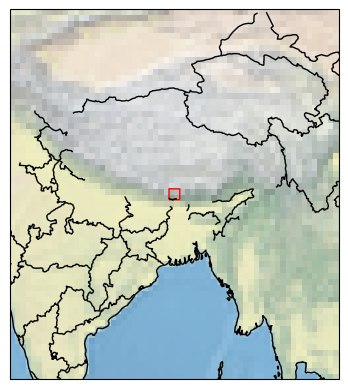

In [11]:
dc_bbox = itslivetools.get_bbox_single(dc)

### NASADEM (local)

In [12]:
dem_dir = '/home/emmamarshall/Desktop/data/nasadem/'
dem_ls = os.listdir(dem_dir)
dem_ls = [dem_ls[element] for element in range(len(dem_ls)) if '.nc' in dem_ls[element]]

In [13]:
dem_paths = [dem_dir + dem_ls[element] for element in range(len(dem_ls))]

In [14]:
qgis_dem = xr.open_dataset('/home/emmamarshall/Desktop/data/nasadem/merged_dem_qgis.nc').squeeze()

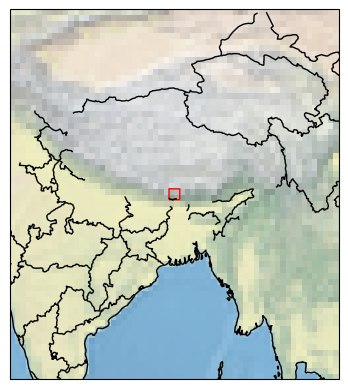

In [15]:
da_bbox = get_bbox_single(dc)
da_bbox = da_bbox.to_crs('EPSG:32645')

### RGI outlines (uploaded to github repo)

In [16]:
rgi = gpd.read_file('https://github.com/e-marshall/itslive/raw/master/rgi15_southasiaeast.geojson')
rgi.head(3)
rgi_prj = rgi.to_crs('epsg:32645')

rgi_sub = gpd.sjoin(rgi_prj, da_bbox, how='inner')

In [17]:
rgi_sub.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,index_right
2696,RGI60-15.02697,G088184E27891N,20001108,-9999999,88.183836,27.890705,15,2,0.526,5512,...,1239,0,0,0,0,9,9,None,"POLYGON ((616219.593 3085917.382, 616223.232 3...",0
2697,RGI60-15.02698,G088155E27898N,20001108,-9999999,88.155126,27.898019,15,2,11.710,5202,...,7398,0,0,0,0,9,9,None,"POLYGON ((617373.178 3088393.887, 617410.220 3...",0
2698,RGI60-15.02699,G088130E27874N,20001108,-9999999,88.129556,27.873683,15,2,3.011,6798,...,2134,0,0,0,0,9,9,None,"POLYGON ((612141.972 3083076.812, 612110.222 3...",0
2699,RGI60-15.02700,G088184E27900N,20001108,-9999999,88.183625,27.899983,15,2,0.313,5392,...,970,0,0,0,0,9,9,None,"POLYGON ((616267.486 3086560.269, 616241.741 3...",0
2700,RGI60-15.02701,G088226E27869N,20001108,-9999999,88.226304,27.868729,15,2,0.081,5721,...,261,0,0,0,0,9,9,None,"POLYGON ((620545.118 3083321.350, 620549.409 3...",0


In [18]:
#list of glaciers w/ term type specified
term_types = pd.read_csv('hma_glacier_term_types_1021.csv')

In [19]:
#just the glaciers that i've categorized term type for so far
rgi_set = rgi_sub.loc[rgi_sub['RGIId'].isin(term_types['RGI_ID'])]
rgi_set.head()

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,index_right
2930,RGI60-15.02931,G088625E27980N,20001108,-9999999,88.625432,27.980324,15,2,0.509,4990,...,1231,0,0,0,0,9,9,None,"POLYGON ((659836.912 3095659.197, 659778.703 3...",0
3251,RGI60-15.03252,G088527E27987N,20001226,-9999999,88.526741,27.986635,15,2,0.695,4971,...,1860,0,0,0,0,9,9,None,"POLYGON ((650180.120 3097075.800, 650174.821 3...",0
3252,RGI60-15.03253,G088519E27998N,20001226,-9999999,88.519156,27.998086,15,2,2.324,4954,...,3490,0,0,0,0,9,9,None,"POLYGON ((649166.828 3098704.766, 649198.432 3...",0
3255,RGI60-15.03256,G088545E28014N,20001226,-9999999,88.545391,28.014097,15,2,0.414,5347,...,1223,0,0,0,0,9,9,None,"POLYGON ((652414.559 3099827.434, 652358.242 3...",0
10384,RGI60-15.10385,G088028E27916N,20100128,-9999999,88.028000,27.916000,15,2,1.523,5726,...,2732,0,0,0,0,9,9,CN5O197B0120,"POLYGON ((600796.268 3087846.068, 600800.974 3...",0


In [20]:
#glims ids of the term type categorized glaciers, to be used to extract centerlines
glims_set = rgi_set['GLIMSId']

In [21]:
#list of glaciers w/ term type specified
term_types = pd.read_csv('hma_glacier_term_types_1021.csv')

In [22]:
term_types

,RGI_ID,TermType
0,RGI60-15.10463,Lake
1,RGI60-15.10464,Lake
2,RGI60-15.10467,possible
3,RGI60-15.1047,possible
4,RGI60-15.03253,possible
5,RGI60-15.03252,possible
6,RGI60-15.02931,Lake
7,RGI60-15.03256,Lake
8,RGI60-15.10459,possible
9,RGI60-15.10458,Land


### Centerline data (local)

from this paper (link)

In [23]:
sa_east_ablationlines = gpd.read_file('/home/emmamarshall/Desktop/data/zhang2022/zhang_2022_ablationlines/15_rgi60_SouthAsiaEast_Ablationlines.shp')
sa_east_centerlines = gpd.read_file('/home/emmamarshall/Desktop/data/zhang2022/zhang_2022_centerlines/15_rgi60_SouthAsiaEast_final_lines.shp')
sa_east_lowestPoints = gpd.read_file('/home/emmamarshall/Desktop/data/zhang2022/zhang_2022_lowestPoints/15_rgi60_SouthAsiaEast_minimumpoints.shp')

In [24]:
!pwd

/home/emmamarshall/Desktop/phd_work/itslive


In [25]:
#subset ablation lines to only glaciers that have been term type categorized so far
#set_ablationlines = sa_east_ablationlines.loc[sa_east_ablationlines['GLIMS_ID'].isin(glims_set)]

#with open('/home/emmamarshall/Desktop/data/written_data/ablationLine_subset.geojson','w') as f:
#    f.write(set_ablationlines.to_json())


In [26]:
sa_east_centerlines.head()

,GLIMS_ID,Type,MaxL,MeanL,ELA,AccL,AblationL,geometry
0,G102044E29941N,1,1278.0,1278.0,5224,556.0,722.0,"LINESTRING (1064475.427 376944.037, 1064474.88..."
1,G102042E29987N,1,1416.0,1217.0,5159,534.0,882.0,"MULTILINESTRING ((1063655.823 381517.030, 1063..."
2,G102041E29997N,1,890.0,890.0,5103,488.0,402.0,"LINESTRING (1063609.564 382931.401, 1063610.50..."
3,G102050E29962N,1,2406.0,2406.0,4978,961.0,1444.0,"LINESTRING (1065455.354 379766.938, 1065447.69..."
4,G102044E30025N,1,1347.0,1149.0,5008,799.0,548.0,"MULTILINESTRING ((1063293.156 385717.107, 1063..."


In [27]:
#sa_east_centerlines.loc[sa_east_centerlines['GLIMS_ID'] == 'G088251E27968N']
sa_east_centerlines.loc[sa_east_centerlines['GLIMS_ID'] == a[0]]

NameError: name 'a' is not defined

## Starting setup of ind glacier object

### some object setup

In [51]:
class IndGlacier:
    
    def __init__(self, rgi_id, rgi_outline, dem, itslive, centerLine=None, ablationLine = None, lowestPoint = None):
        
        self.rgi_id = rgi_id
        self.rgi_outline = rgi_outline
        self.dem = dem
        self.itslive = itslive
        self.centerLine = centerLine
        self.ablationLine = ablationLine
        self.lowestPoint = lowestPoint
    
    def calc_flowline_distance(self):
        '''function to calculate distance from glacier terminus along flowline. should ultimately be a method of the Glacier class.
    takes an endpoint object and a ablation line vector. should return a 1D array with distance from terminus (or maybe a geodataframe with each point and dist as an attr??
    NO - doesn't take endpont, only ablation line because the end point does not always lie along the ablation line -- not sure the best way to handle this'''

   
    
        dl = np.zeros(len(list(self.ablationLine['geometry'].iloc[0].coords))) # make an empty array the list of the ablation line vector

        #dl = np.zeros(5)

        coords = list(self.ablationLine['geometry'].iloc[0].coords)

        coords_X = [coords[point][0] for point in range(len(coords))]
        coords_Y = [coords[point][1] for point in range(len(coords))]

        dl[1:] = np.sqrt(np.diff(coords_X)**2 + np.diff(coords_Y)**2)

        dist_profile = pd.DataFrame({'x_coords': coords_X,
                                 'y_coords': coords_Y,
                                 'distance': np.cumsum(dl)})
    
        geometry = gpd.points_from_xy(dist_profile['x_coords'], dist_profile['y_coords'])

        gdf = gpd.GeoDataFrame(
            dist_profile, geometry= geometry)
        
        gdf['ind_dist'] = gdf['distance'].diff()
        gdf['x_diff'] = gdf['x_coords'].diff()
        gdf['y_diff'] = gdf['y_coords'].diff()

        # 'downsample' remove points closer to one another than 50 meters
        #gdf_downsamp = gdf.loc[gdf['ind_dist'] >= 30]
        # ^^^^ should I downsample or not? turns out that wasn't the memory issue so don't need to

        #make list of tuples of flowline coords
        flowline_points_ls = [(gdf['x_coords'].iloc[row], gdf['y_coords'].iloc[row]) for row in range(len(gdf))]
        #list into array
        flowline_points = np.array(flowline_points_ls)
        #make xr objects of x and y coordinates with a new dimension 'points'
        x = xr.DataArray(flowline_points[:,0], dims = 'points')
        y = xr.DataArray(flowline_points[:,1], dims = 'points')
        #make new xr object that is velocity data interpolated onto the points
        interp_points = self.itslive.interp(x=x, y=y)
        #reverse index so that first points are terminus, last are end of ablation zone
        interp_points = interp_points.reindex(points = list(reversed(interp_points.points)))
        
        flowline_xr = gdf.to_xarray()
        flowline_xr = flowline_xr.reindex(index = list(reversed(flowline_xr.index)))

        interp_points['distance'] = ('points', flowline_xr.distance.data )



        return interp_points

In [36]:
#steps to do outside of function on entire data object (for dem and itslive): write crs
qgis_dem = qgis_dem.rio.write_crs('EPSG:4326')
dc = dc.rio.write_crs('EPSG:32645')
#reproject dem to local utm
dem_prj = qgis_dem.rio.reproject('EPSG:32645')

In [60]:
def ind_glacier_data_prep(rgi_id, rgi_full, itslive_dc, dem_obj, centerlines, ablationlines, lowestpoints, utm_code):
    '''function to prepare data to create an object of the `IndGlacier` class for a single glacier.
    Pass in RGI ID of glacier of interest as well as full data objects of RGI gpdf, itslive datacube, 
    nasadem and the u tm code fo the glacier.I feel like at scale this is probably a really inefficient way to build objects'''
    
    #clip rgi to glacier
    single_rgi = rgi_full.loc[rgi_full['RGIId'] == rgi_id]
    #extract glims id - will use to extract centerlines
    glims_id = single_rgi['GLIMSId'].values
    
    
    #clip dem and itslive
    dem_clip = dem_obj.rio.clip(single_rgi.geometry, dem_obj.rio.crs).squeeze().transpose()
    itslive_clip = itslive_dc.rio.clip(single_rgi.geometry, itslive_dc.rio.crs)
    dem_clip_downsamp = dem_clip.interp_like(itslive_clip, method = 'nearest')
    itslive_clip['z'] = dem_clip_downsamp.Band1
    
    #centerline objects
    centerline = centerlines.loc[centerlines['GLIMS_ID'] == glims_id[0]].to_crs(utm_code)
    ablationline = ablationlines.loc[ablationlines['GLIMS_ID'] == glims_id[0]].to_crs(utm_code)
    lowestpoint = lowestpoints.loc[lowestpoints['GLIMS_ID'] == glims_id[0]].to_crs(utm_code)
    
    #flowline object
    
    #centerline = centerline.to_crs(utm_code)
    #ablationline = ablationline.to_crs(utm_code)
    #lowestpoint = lowestpoints.to_crs(
    
    #creat object of IndGlacier class
    rgi_outline = single_rgi
    glacier = IndGlacier(rgi_id, rgi_outline, dem_clip_downsamp, itslive_clip, centerline, ablationline, lowestpoint)
    
    return glacier

Not sure if there's any benefit/ hindrance to having the dem and itslive xarray objects not be joined into one object? they're both accessible from the IndGlacier object but they're on the same grid so maybe they should just all be one xr dataset? 

In [37]:
g10463 = itslive_setup.ind_glacier_data_prep('RGI60-15.10463', rgi_sub, dc, dem_prj, sa_east_centerlines, sa_east_ablationlines, sa_east_lowestPoints, 'EPSG:32645')

In [43]:
fl_10463 = g10463.calc_flowline()

NameError: name 'np' is not defined

In [42]:
fl_10463.v_error.mean(dim='mid_date').plot()

NameError: name 'fl_10463' is not defined

In [96]:
x

<xarray.DataArray 'distance' (points: 221)>
array([4405.34527869, 4405.29033608, 4402.99962846, 4401.10412307,
       4399.13754954, 4397.17008868, 4390.28141048, 4387.3292868 ,
       4385.36162423, 4383.4035981 , 4377.52800787, 4362.83578819,
       4352.05709828, 4349.12209604, 4347.17237629, 4346.20082153,
       4345.23179177, 4344.26469896, 4343.28740936, 4342.3081596 ,
       4341.32628345, 4340.3421289 , 4338.36823261, 4335.40017732,
       4321.53892226, 4311.64207747, 4306.78403851, 4288.40863365,
       4283.57316603, 4278.75248676, 4260.43362123, 4255.58964527,
       4249.6650662 , 4231.888698  , 4224.96981087, 4218.04313808,
       4215.08350138, 4213.12655454, 4212.15719266, 4211.19583128,
       4210.24303956, 4209.29699501, 4208.34085996, 4207.37781442,
       4206.40601871, 4205.42602422, 4204.43942347, 4202.45278186,
       4187.46292326, 4150.5373464 , 4145.54880177, 4143.55425453,
       4142.55594822, 4140.55881254, 4136.56322975, 4036.65693462,
       4032.66144522, 4029.66876611, 4027.6774663 , 4023.69388977,
       3871.30670964, 3866.32698582, 3864.3354196 , 3862.34468035,
       3857.36859387, 3655.31133935, 3650.33477632, 3646.3577306 ,
       3640.39812009, 3509.28191978, 3502.32913041, 3495.37361881,
       3388.05565035, 3384.0816133 , 3381.10266465, 3378.12450318,
       3374.15150214, 3346.33490643, 3236.06335054, 3232.08986558,
...
       2065.12279296, 2063.13811196, 2061.15165922, 2058.16918645,
       2041.26065723, 1969.65327206, 1963.68605063, 1960.71366783,
       1955.76900878, 1878.63101764, 1875.66469451, 1872.69955773,
       1871.71146711, 1869.72770191, 1866.75089354, 1826.05147893,
       1822.08110568, 1819.10772148, 1813.17596893, 1755.83069053,
       1750.88791643, 1747.90661675, 1741.92647358, 1565.49413273,
       1559.51382095, 1556.53497832, 1551.60543118, 1496.38598011,
       1492.44223569, 1489.46413894, 1377.27400201, 1262.29658283,
       1062.73164225, 1058.74095772, 1055.74931662, 1052.77204448,
       1048.80075976,  993.19312206,  942.5504129 ,  939.57182806,
        937.58661378,  935.6018579 ,  934.60328814,  931.60677278,
        927.61000374,  724.75458899,  719.75917404,  717.76168523,
        716.76270089,  713.76512009,  709.76711268,  464.866298  ,
        461.86812725,  458.87163628,  456.98320528,  452.53440523,
        450.75781839,  449.77812016,  447.81460712,  445.49645977,
        442.8967745 ,  437.98589691,  428.3360517 ,  426.39403216,
        424.4644529 ,  422.5362627 ,  421.54216937,  419.55285223,
        417.56200015,  251.22240718,   22.07820269,   18.6285004 ,
         15.99442416,   13.63172487,   12.14437594,   11.57440862,
          0.        ])
Coordinates:
    mapping  int64 0
    crs      int64 0
    x        (points) float64 6.236e+05 6.236e+05 ... 6.221e+05 6.221e+05
    y        (points) float64 3.094e+06 3.094e+06 ... 3.098e+06 3.098e+06
  * points   (points) int64 220 219 218 217 216 215 214 213 ... 7 6 5 4 3 2 1 0

In [112]:
v_error = e.load()

In [120]:
x = fl_10463.distance
y = fl_10463.v.mean(dim='mid_date')
e = fl_10463.v_error.mean(dim='mid_date')
N=221
a = (100 * np.random.rand(N))
z = fl_10463.z

/home/emmamarshall/miniconda3/envs/itslive_work/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/emmamarshall/miniconda3/envs/itslive_work/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


AttributeError: module 'matplotlib.pyplot' has no attribute 'set_ylim'

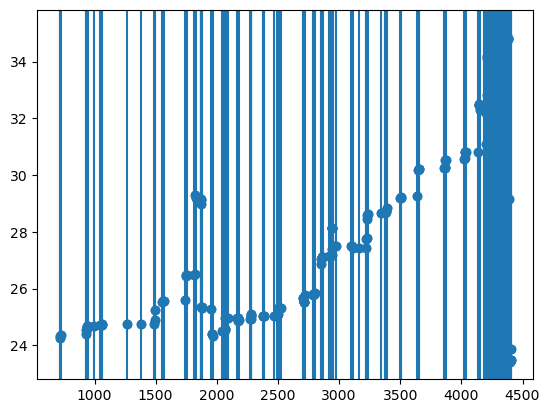

In [125]:
plt.scatter(x,y)
plt.errorbar(x,y, yerr = v_error, fmt = 'o')
plt.set_ylim(-50,100)
plt.show()

In [83]:
g10463.centerLine

,GLIMS_ID,Type,MaxL,MeanL,ELA,AccL,AblationL,geometry
10347,G088251E27968N,2,6242.0,5895.0,5992,1836.0,4406.0,"MULTILINESTRING ((624093.734 3092367.776, 6240..."


/home/emmamarshall/miniconda3/envs/itslive_work/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/emmamarshall/miniconda3/envs/itslive_work/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


<AxesSubplot:label='Mean velocity over time over entire glacier. \n Ablation line flowline in red corresponds to points plotted in fig.1', title={'center':'mapping = 0, crs = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

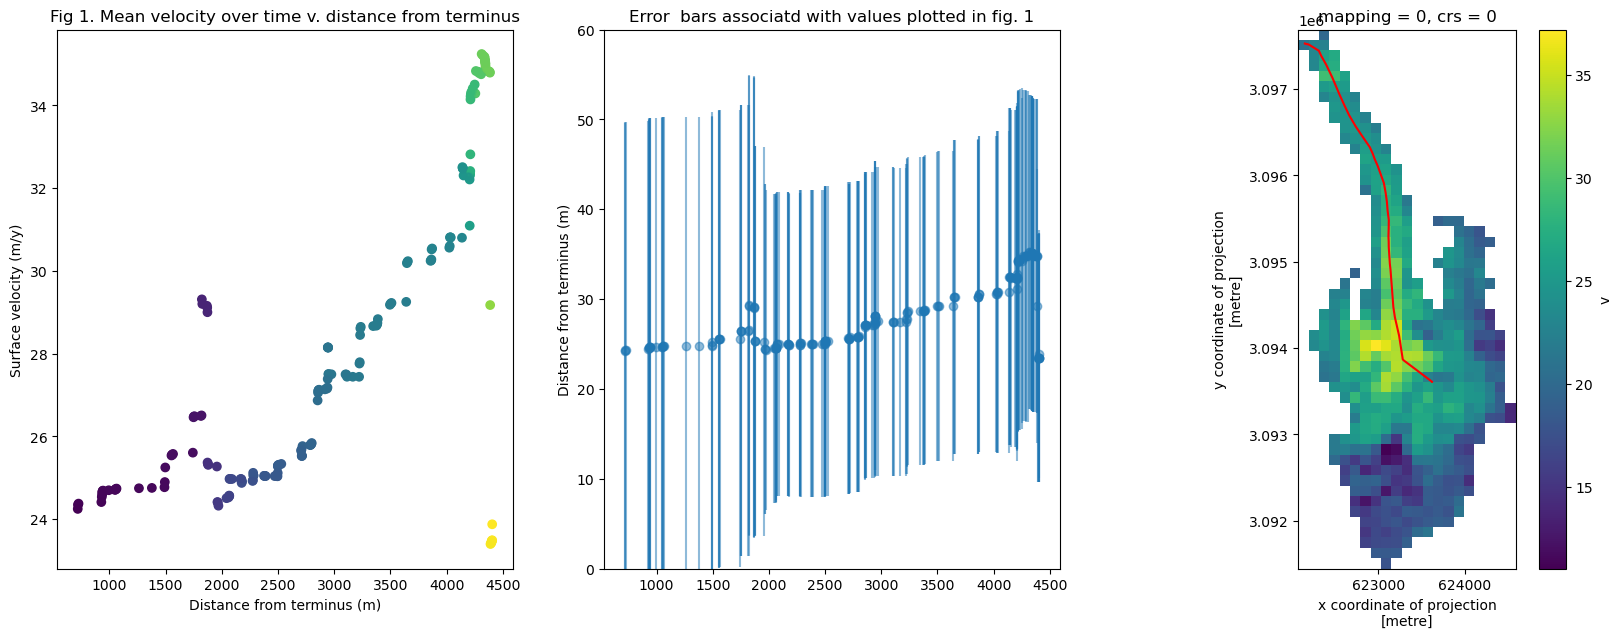

In [135]:
fig, axs = plt.subplots(ncols =3 ,figsize = (20,7))
axs[0].scatter(x,y, c = z)
axs[0].scatter(x,y, c = z, s = e, alpha = 0.5)
axs[0].set_title('Fig 1. Mean velocity over time v. distance from terminus')
axs[1].errorbar(x,y, yerr = v_error, fmt = 'o', alpha = 0.5)
axs[1].set_ylim(0,60)
axs[1].set_title('Error  bars associatd with values plotted in fig. 1')
axs[1].set_ylabel('m/y')
axs[1].set_ylabel('Distance from terminus (m)')
axs[0].set_ylabel('Surface velocity (m/y)')
axs[0].set_xlabel('Distance from terminus (m)')

axs[2].set_label('Mean velocity over time over entire glacier. \n Ablation line flowline in red corresponds to points plotted in fig.1')
axs[2].set_ylabel('Y coordinate of projection (m)')
axs[2].set_xlabel('X coordinate of projection (m)')

                 
g10463.itslive.v.mean(dim='mid_date').plot(ax=axs[2])
g10463.ablationLine.plot(ax=axs[2], color='red')

#plt.show()

<AxesSubplot:title={'center':'mid_date = 2021-02-23T04:51:03.527088128, mappi...'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

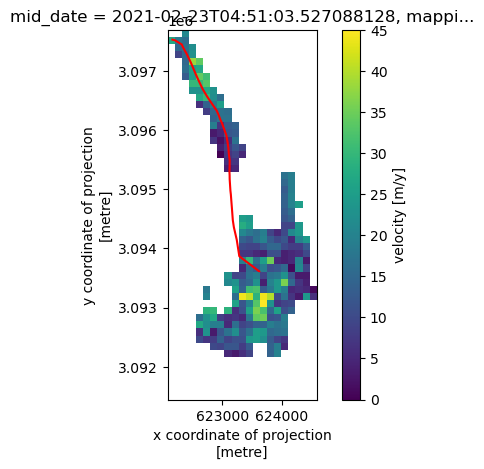

In [68]:
fig, ax = plt.subplots()
g10463.itslive.v.isel(mid_date=100).plot(ax=ax)
g10463.ablationLine.plot(ax=ax, color='red')

I think the memory issues on the interpolation step are caused by the density of points along the ablation line vector. velocity data is 120 m resolution so don't need flowline data finer than that, just need to figure out how to downsample the flowline vector...

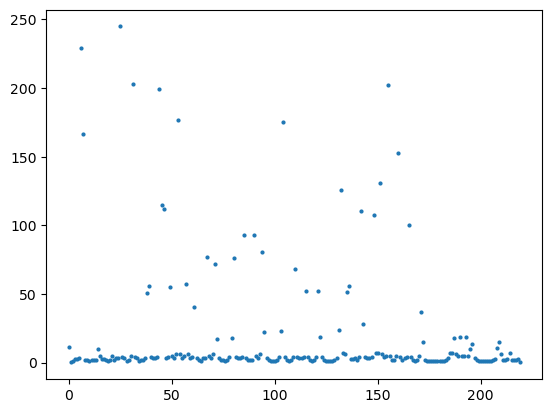

In [69]:
plt.plot(np.diff(flowline['distance']), marker = 'o', linestyle='None', markersize=2)

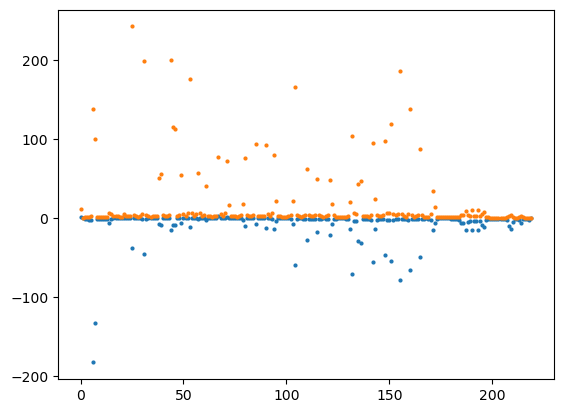

In [70]:
plt.plot(np.diff(flowline['x_coords']), marker = 'o', linestyle='None', markersize=2)
plt.plot(np.diff(flowline['y_coords']), marker = 'o', linestyle='None', markersize=2)

<AxesSubplot:>

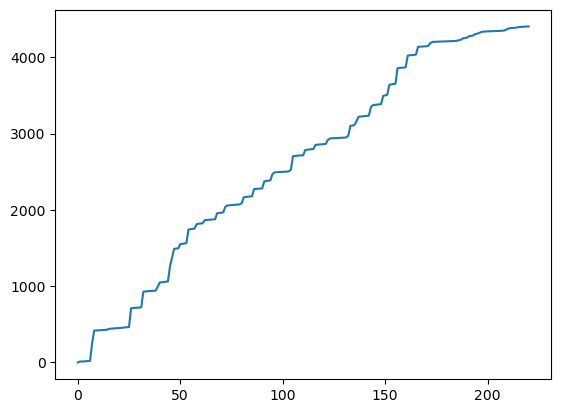

In [71]:
flowline['distance'].plot()

### Interpolating velocity data along flowline

Now we have a dataframe with flowline coordinates and corresonding distances along flowline. Need to extract the itslive velocity data corresponding to these points

In [72]:
def interp_flowline(flowline):
    
    #add more cols to the flowline object
    flowline['ind_dist'] = flowline['distance'].diff()
    flowline['x_diff'] = flowline['x_coords'].diff()
    flowline['y_diff'] = flowline['y_coords'].diff()

    # 'downsample' remove points closer to one another than 50 meters
    #flowline_downsamp = flowline.loc[flowline['ind_dist'] >= 50]
    # ^^^^ should I downsample or not? turns out that wasn't the memory issue so don't need to
    
    #make list of tuples of flowline coords
    flowline_points_ls = [(flowline['x_coords'].iloc[row], flowline['y_coords'].iloc[row]) for row in range(len(flowline))]
    #list into array
    flowline_points = np.array(flowline_points_ls)
    #make xr objects of x and y coordinates with a new dimension 'points'
    x = xr.DataArray(flowline_points[:,0], dims = 'points')
    y = xr.DataArray(flowline_points[:,1], dims = 'points')
    #make new xr object that is velocity data interpolated onto the points
    interp_points = g10463.itslive.interp(x=x, y=y)
    #reverse index so that first points are terminus, last are end of ablation zone
    interp_points = interp_points.reindex(points = list(reversed(interp_points.points)))

In [73]:
flowline_x = flowline_downsamp['x_coords']
flowline_y = flowline_downsamp['y_coords']

In [74]:
flowline_downsamp['x_coords'].iloc[5]

623175.2494293822

In [75]:
flowline_points_ls = [(flowline_downsamp['x_coords'].iloc[row], flowline_downsamp['y_coords'].iloc[row]) for row in range(len(flowline_downsamp))]

In [76]:
flowline_points_ls[0]

(623431.877110091, 3093753.781406924)

In [77]:
flowline_points = np.array(flowline_points_ls)

In [78]:
flowline_points[:5]

array([[ 623431.87711009, 3093753.78140692],
       [ 623298.91820521, 3093853.73534533],
       [ 623241.9297473 , 3094135.99592221],
       [ 623193.91215484, 3094348.46545622],
       [ 623183.55220373, 3094413.20982636]])

How best to interpolate gridded data for points? 
helpful answer [here](https://stackoverflow.com/questions/68614932/interpolating-an-xarray-dataarray-for-n-points-and-getting-a-list-of-n-interpola)

In [79]:
x = xr.DataArray(flowline_points[:,0], dims = 'points')
y = xr.DataArray(flowline_points[:,1], dims = 'points')

In [80]:
interp_points = g10463.itslive.interp(x=x, y=y)

In [81]:
interp_points = interp_points.reindex(points = list(reversed(interp_points.points)))

In [82]:
g10463.rgi_outline

,RGIId,GLIMSId,BgnDate,EndDate,CenLon,CenLat,O1Region,O2Region,Area,Zmin,...,Lmax,Status,Connect,Form,TermType,Surging,Linkages,Name,geometry,index_right
10462,RGI60-15.10463,G088251E27968N,20100128,-9999999,88.251,27.968,15,2,6.924,5335,...,6668,0,0,0,0,9,9,CN5O197B0030,"POLYGON ((624579.834 3093180.112, 624573.058 3...",0


<AxesSubplot:>

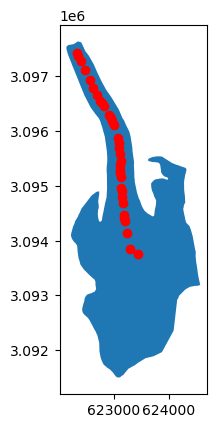

In [83]:
type(flowline_downsamp)
fig, ax = plt.subplots()

g10463.rgi_outline.plot(ax=ax)
flowline_downsamp.plot(ax=ax, color = 'red')


<AxesSubplot:title={'center':'mapping = 0'}, xlabel='x coordinate of projection\n[metre]', ylabel='y coordinate of projection\n[metre]'>

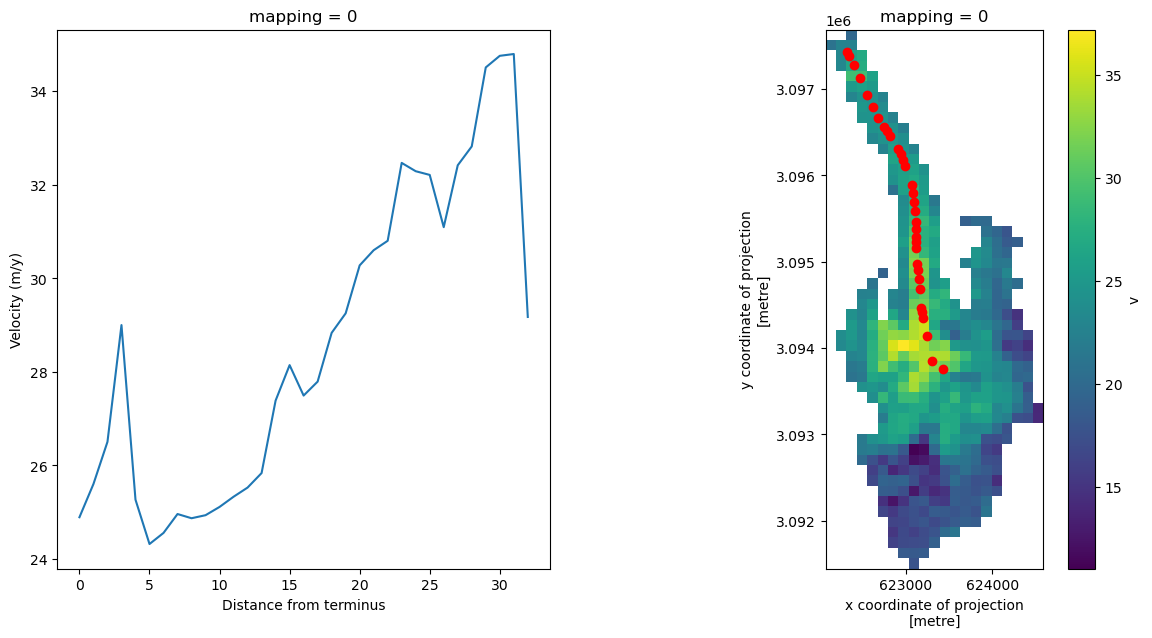

In [84]:
fig, axs = plt.subplots(ncols=2, figsize=(14,7))
interp_points.v.mean(dim='mid_date').plot(ax=axs[0])
axs[0].set_xlabel('Distance from terminus')
axs[0].set_ylabel('Velocity (m/y)')

g10463.itslive.v.mean(dim='mid_date').plot(ax=axs[1])
flowline_downsamp.plot(ax=axs[1], color = 'red')



In [85]:
v0_flowline = interp_points.isel(points=0).v.compute()
v221_flowline = interp_points.isel(points=220).v.compute()

IndexError: Index 220 is out of bounds for axis 1 with size 33

In [ ]:
interp_points

Great, now have an xarray dataset of points corresponding to the flowline. Would like to convert it to a geopandas df. might need to be a a multi index with the time series? 
Useful tips [here](https://stackoverflow.com/questions/65504116/how-to-convert-a-xarray-dataarray-to-a-geopandas-geodataframe)

In [ ]:
v_flowline_df = interp_points.v.to_dataframe().reset_index()

In [46]:
v_flowline_df.head()

,mid_date,points,mapping,x,y,v
0,2022-01-04 04:51:04.527088128,0,0,623621.609203,3.093597e+06,NaN
1,2022-01-04 04:51:04.527088128,1,0,623622.770204,3.093609e+06,NaN
2,2022-01-04 04:51:04.527088128,2,0,623622.347088,3.093609e+06,NaN
3,2022-01-04 04:51:04.527088128,3,0,623621.214544,3.093610e+06,NaN
4,2022-01-04 04:51:04.527088128,4,0,623619.382615,3.093612e+06,NaN


In [ ]:
gdf = gpd.GeoDataFrame(
    v_flowline_df.v, geometry = gpd.points_from_xy(v_flowline_df.x, v_flowline_df.y))

In [88]:
print(v0_flowline['x'].data)
print(v0_flowline['y'].data)
print('')
print(v221_flowline['x'].data)
print(v221_flowline['y'].data)
        

623621.6092028858
3093597.393436594

622137.837502642
3097528.2207665457


In [83]:
print(v0_flowline.mean(dim='mid_date').values)
print(v221_flowline.mean(dim='mid_date').values)

23.872916255167283
nan


In [68]:
flowline_dist = flowline_downsamp[['x_coords','y_coords','distance','geometry']]
flowline_dist_xr = flowline_dist.to_xarray()

In [70]:
flowline_dist_xr = flowline_dist_xr.reset_index('index').assign_coords({'x':flowline_dist_xr.x_coords.data,'y':flowline_dist_xr.y_coords.data})

In [71]:
flowline_dist_xr.isel(index=

<xarray.Dataset>
Dimensions:   (index: 31, x: 31, y: 31)
Coordinates:
  * index     (index) int64 7 8 26 32 39 40 45 ... 137 143 149 152 156 161 166
  * x         (x) float64 6.234e+05 6.233e+05 6.232e+05 ... 6.224e+05 6.223e+05
  * y         (y) float64 3.094e+06 3.094e+06 3.094e+06 ... 3.097e+06 3.097e+06
Data variables:
    x_coords  (index) float64 6.234e+05 6.233e+05 ... 6.224e+05 6.223e+05
    y_coords  (index) float64 3.094e+06 3.094e+06 ... 3.097e+06 3.097e+06
    distance  (index) float64 251.2 417.6 709.8 ... 4.024e+03 4.137e+03
    geometry  (index) object POINT (623431.877110091 3093753.781406924) ... P...

In [51]:
interp_points['distance'] = (flowline_dist)

In [56]:
interp_points

<xarray.Dataset>
Dimensions:                    (mid_date: 25372, points: 221, dim_0: 31,
                                dim_1: 2)
Coordinates:
    mapping                    int64 0
  * mid_date                   (mid_date) datetime64[ns] 2022-01-04T04:51:04....
    x                          (points) float64 6.236e+05 ... 6.221e+05
    y                          (points) float64 3.094e+06 ... 3.098e+06
  * dim_0                      (dim_0) int64 7 8 26 32 39 ... 152 156 161 166
  * dim_1                      (dim_1) object 'distance' 'geometry'
Dimensions without coordinates: points
Data variables: (12/54)
    acquisition_date_img1      (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    acquisition_date_img2      (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    autoRIFT_software_version  (mid_date) <U5 dask.array<chunksize=(25372,), meta=np.ndarray>
    chip_size_height           (mid_date, points) float32 dask.array<chunksize=(25372, 221), meta=np.ndarray>
    chip_size_width            (mid_date, points) float32 dask.array<chunksize=(25372, 221), meta=np.ndarray>
    date_center                (mid_date) datetime64[ns] dask.array<chunksize=(25372,), meta=np.ndarray>
    ...                         ...
    vy_error_modeled           (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_error_slow              (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift            (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift_mask       (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    vy_stable_shift_slow       (mid_date) float64 dask.array<chunksize=(25372,), meta=np.ndarray>
    distance                   (dim_0, dim_1) object 251.22240718303095 ... P...
Attributes: (12/18)
    GDAL_AREA_OR_POINT:         Area
    author:                     ITS_LIVE, a NASA MEaSUREs project (its-live.j...
    autoRIFT_parameter_file:    http://its-live-data.s3.amazonaws.com/autorif...
    datacube_software_version:  1.0
    date_created:               14-Jun-2022 04:37:25
    date_updated:               14-Jun-2022 04:37:25
    ...                         ...
    s3:                         s3://its-live-data/datacubes/v02/N20E080/ITS_...
    skipped_granules:           s3://its-live-data/datacubes/v02/N20E080/ITS_...
    time_standard_img1:         UTC
    time_standard_img2:         UTC
    title:                      ITS_LIVE datacube of image_pair velocities
    url:                        https://its-live-data.s3.amazonaws.com/datacu...

In [45]:
interp_points_df = interp_points.v.to_dataframe()

In [46]:
interp_points_df

mapping              x             y   v
mid_date                      points                                          
2022-01-04 04:51:04.527088128 0             0  623621.609203  3.093597e+06 NaN
                              1             0  623622.770204  3.093609e+06 NaN
                              2             0  623622.347088  3.093609e+06 NaN
                              3             0  623621.214544  3.093610e+06 NaN
                              4             0  623619.382615  3.093612e+06 NaN
...                                       ...            ...           ...  ..
2017-02-16 04:36:00.527088128 216           0  622143.865712  3.097527e+06 NaN
                              217           0  622141.968944  3.097527e+06 NaN
                              218           0  622140.127646  3.097528e+06 NaN
                              219           0  622137.891305  3.097528e+06 NaN
                              220           0  622137.837503  3.097528e+06 NaN

[5607212 rows x 4 columns]

/tmp/ipykernel_182917/1991598222.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(interp.x, interp.y, interp.v.mean(dim='mid_date'))


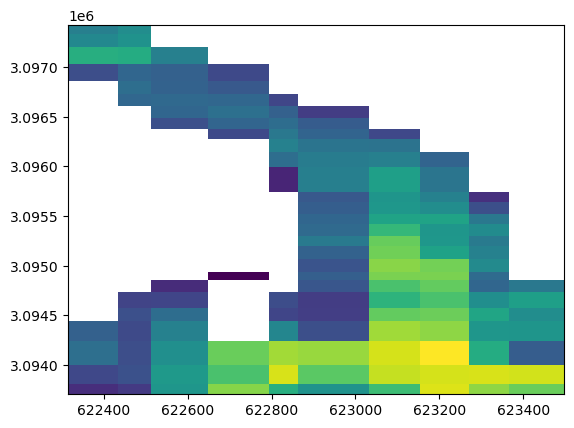

In [90]:
plt.pcolormesh(interp.x, interp.y, interp.v.mean(dim='mid_date'))

In [60]:
interp_v_df = interp.v.mean(dim='mid_date').to_dataframe()

In [61]:
interp_v_df

mapping          v
y            x                                
3.093754e+06 623431.877110        0  29.172382
             623298.918205        0  31.928125
             623241.929747        0  33.130978
             623193.912155        0  33.275650
             623183.552204        0  32.952171
...                             ...        ...
3.097376e+06 622614.298516        0        NaN
             622554.131163        0        NaN
             622469.597583        0  27.114120
             622397.838817        0  26.408197
             622343.137871        0  25.604189

[961 rows x 2 columns]

In [56]:
#interp_v_df = interp_v_df.reset_index()

In [62]:
interp_v_xr = interp_v_df.to_xarray()

/tmp/ipykernel_182917/2395197477.py:1: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(interp_v_xr['x'], interp_v_xr['y'], interp_v_xr['v'])


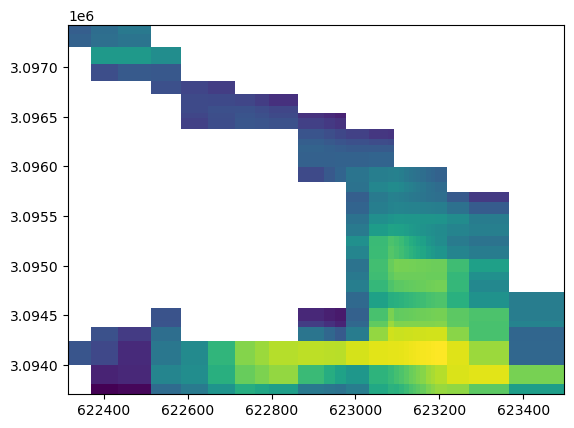

In [78]:
plt.pcolormesh(interp_v_xr['x'], interp_v_xr['y'], interp_v_xr['v'])

ValueError: The input coordinate is not sorted in increasing order along axis 0. This can lead to unexpected results. Consider calling the `sortby` method on the input DataArray. To plot data with categorical axes, consider using the `heatmap` function from the `seaborn` statistical plotting library.

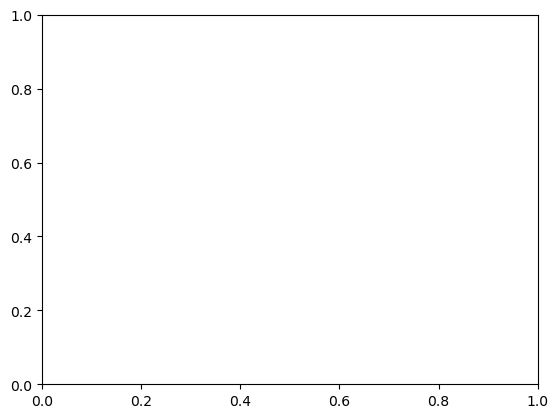

In [72]:
interp_v_xr.v.plot.pcolormesh()

In [ ]:
#interp.to_zarr('g10463_flowline.zarr')

In [29]:
#interp_tmean = interp.v.mean(dim='mid_date')

In [ ]:
#flowline_mean_v_df = interp_tmean.to_dataframe()

In [31]:
interp = interp.chunk({'mid_date': 'auto'})

In [ ]:
interp.to_zarr('g10463_flowline.zarr')

In [32]:
#interp_v

<xarray.DataArray 'v' (mid_date: 25372, y: 221, x: 221)>
dask.array<rechunk-merge, shape=(25372, 221, 221), dtype=float32, chunksize=(687, 221, 221), chunktype=numpy.ndarray>
Coordinates:
    mapping   int64 0
  * mid_date  (mid_date) datetime64[ns] 2022-01-04T04:51:04.527088128 ... 201...
  * x         (x) float64 6.236e+05 6.236e+05 6.236e+05 ... 6.221e+05 6.221e+05
  * y         (y) float64 3.094e+06 3.094e+06 3.094e+06 ... 3.098e+06 3.098e+06
Attributes:
    description:    velocity magnitude
    grid_mapping:   mapping
    standard_name:  velocity
    units:          m/y

Discussion of `xr.to_dataframe()` with dask arrays [here](https://stackoverflow.com/questions/40475884/how-to-convert-an-xarray-dataset-to-pandas-dataframes-inside-a-dask-dataframe). Could help with the issues i'm having?

In [ ]:
#v_flowline_df = interp.v.mean(dim='mid_date').to_dataframe()

In [79]:
coord1 = list(flowline.iloc[0]['geometry'].coords)[0]
coord_mid = list(flowline.iloc[-50]['geometry'].coords)[0]
coord_end = list(flowline.iloc[-30]['geometry'].coords)[0]

Text(0.5, 0.98, 'velocity at individual points along flowline over time')

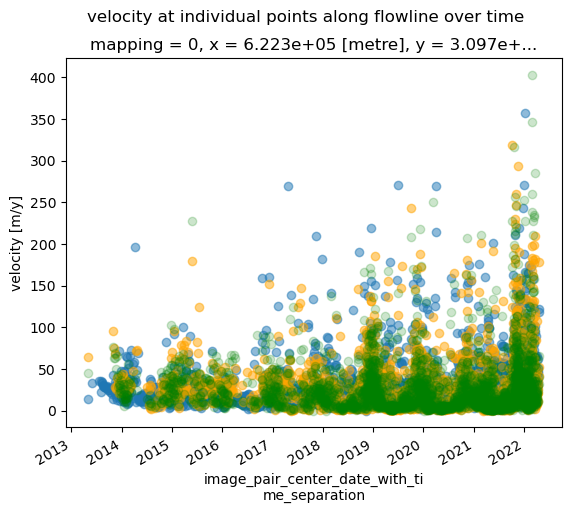

In [81]:
#g10463.itslive.sel(x = coord[1], y = coord[0] , method = 'nearest').v.plot()
fig, axs = plt.subplots(ncols=2, figsize=(12,6))
g10463.itslive.v.interp(x = coord1[0], y = coord1[1]).plot(marker='o', linestyle='None', ax=axs[0], alpha = 0.5)
g10463.itslive.v.interp(x = coord_mid[0], y = coord_mid[1]).plot(marker='o', linestyle='None', ax=axs[0], color='orange', alpha = 0.5)
g10463.itslive.v.interp(x = coord_end[0], y = coord_end[1]).plot(marker= 'o', linestyle='None', ax=axs[0], color = 'green', alpha = 0.2)
plt.suptitle('velocity at individual points along flowline over time')

In [461]:
g10463.ablationLine

,GLIMS_ID,Type,MaxL,MeanL,ELA,AccL,AblationL,geometry
10347,G088251E27968N,2,6242.0,5895.0,5992,1836.0,4406.0,"LINESTRING (623621.609 3093597.393, 623622.770..."


<AxesSubplot:>

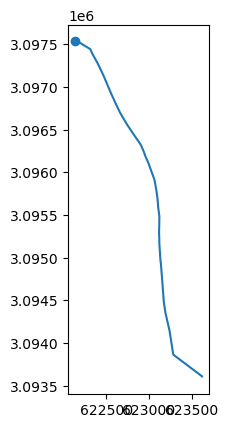

In [202]:
fig, ax = plt.subplots()
g10463.ablationLine.plot(ax=ax)
g10463.lowestPoint.plot(ax=ax)

In [1]:
def calc_flowline_distance(obj):
    '''function to calculate distance from glacier terminus along flowline. should ultimately be a method of the Glacier class.
    takes an endpoint object and a ablation line vector. should return a 1D array with distance from terminus (or maybe a geodataframe with each point and dist as an attr??
    NO - doesn't take endpont, only ablation line because the end point does not always lie along the ablation line -- not sure the best way to handle this'''

   
    
    dl = np.zeros(len(list(obj.ablationLine['geometry'].iloc[0].coords))) # make an empty array the list of the ablation line vector
    
    #dl = np.zeros(5)
    
    sample_coords = list(obj.ablationLine['geometry'].iloc[0].coords)
    
    sample_coords_X = [sample_coords[point][0] for point in range(len(sample_coords))]
    sample_coords_Y = [sample_coords[point][1] for point in range(len(sample_coords))]

    dl[1:] = np.sqrt(np.diff(sample_coords_X)**2 + np.diff(sample_coords_Y)**2)
    
    dist_profile = pd.DataFrame({'x_coords': sample_coords_X,
                                 'y_coords': sample_coords_Y,
                                 'distance': np.cumsum(dl)})
    
    geometry = gpd.points_from_xy(dist_profile['x_coords'], dist_profile['y_coords'])
    
    gdf = gpd.GeoDataFrame(
        dist_profile['distance'], geometry= geometry)
                    
    #return np.cumsum(dl)
    return gdf
    


In [2]:
flowline = calc_flowline_distance(g10463)

NameError: name 'g10463' is not defined